### Evaluation of preprocessing

Successfully converted everything to be numerical 
Gonna have to change the los from a duration type to number of days with float type 
Other than that, loading the saved pre-processed dataframes and plugging them into sklearn instantiations is working so far 

#### Dimensionality reduction

In [1]:
# Feature extraction to create new features that are combinations of original ones 
#(to decrease overfitting but increases training and prediction time)

In [ ]:
# 5 out of 20 need reduction (LOS)

Truncated Singular Value Decomposition (SVD):

SVD is a matrix factorization technique that can handle sparse matrices efficiently.
It decomposes the sparse matrix into three matrices: U, Σ, and V^T, where Σ contains the singular values.
By truncating the number of singular values, you can reduce the dimensionality of the data while retaining the most significant information.
SVD is commonly used for latent semantic analysis (LSA) in natural language processing (NLP) tasks.

Non-negative Matrix Factorization (NMF):

NMF is a matrix factorization technique that decomposes the sparse matrix into two non-negative matrices: W and H.
It assumes that the original data and the factors are non-negative, making it suitable for count-based data such as text documents.
NMF can provide interpretable low-dimensional representations, as the resulting factors are non-negative and additive.

Sparse PCA:

Sparse PCA extends PCA to handle sparse data efficiently.
It introduces sparsity constraints on the loadings matrix, encouraging many loadings to be zero.
Sparse PCA is useful when you want a more interpretable solution with only a subset of features contributing to each principal component.

Random Projection:

Random projection is a technique that projects high-dimensional data onto a lower-dimensional subspace using random matrices.
It preserves pairwise distances between data points approximately, making it suitable for dimensionality reduction tasks.
Random projection is computationally efficient and can handle very high-dimensional data, including sparse matrices.

Sparse Coding:

Sparse coding is a technique that learns a sparse representation of data using overcomplete dictionaries.
It encourages the learned representations to be sparse, meaning that only a small number of dictionary elements are activated for each input.
Sparse coding can be applied to sparse matrices to learn compact representations while maintaining sparsity.

Chose to use truncatedSVD as it is fast and shows a high preservation of variance, more explainable than the others but only really compared them all on the omr dataframe for times sake 

#### Planning for feature selection next stage (informative features)

In [ ]:
# Correlation plots for dfs with fewer features 

In [ ]:
# Look up how to assess feature importance after the model has been trained 

#### L1 lasso and L2 ridge regularization (ElasticNet regression)

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# External libraries for data processing
import numpy as np
import pandas as pd
import sklearn as sk
#To render graphs within notebook
%matplotlib inline
import matplotlib.pyplot as plt
import joblib 
import os

# Versions of libraries
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("Scikit version: {}".format(sk.__version__))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

Numpy version: 1.24.3
Pandas version: 1.5.3
Scikit version: 1.3.0


In [3]:
path = "C:/Users/jenni/OneDrive/Desktop/IP/"
file = "omr_data_train.csv"
full_path = path + file

omr_data_train = pd.read_csv(full_path)

file = "omr_data_test.csv"
full_path = path + file

omr_data_test = pd.read_csv(full_path)

file = "omr_label_train.csv"
full_path = path + file

omr_label_train = pd.read_csv(full_path)

file = "omr_label_test.csv"
full_path = path + file

omr_label_test = pd.read_csv(full_path)

#### Truncated SVD

In [4]:
from sklearn.decomposition import TruncatedSVD

# Number of desired features (components)
n_components = 12

# Initialize Truncated SVD with the desired number of components
svd = TruncatedSVD(n_components=n_components)

# Fit the Truncated SVD model to the sparse matrix and transform the data
svd.fit(omr_data_train)
X_train = svd.transform(omr_data_train)

# Get the explained variance ratio (how much variance is explained by each component)
explained_variance_ratio = svd.explained_variance_ratio_

# Print the transformed matrix and explained variance ratio
# print("Transformed Matrix:")
# print(transformed_matrix)
print("\nExplained Variance Ratio:")
print(explained_variance_ratio)

print("\n Amount of original variance conserved for train:", np.sum(svd.explained_variance_ratio_))


Explained Variance Ratio:
[0.33342246 0.10604019 0.08112751 0.04986413 0.04427745 0.03792265
 0.03462321 0.0305539  0.02590207 0.02647114 0.02490941 0.0234785 ]

 Amount of original variance conserved for train: 0.8185926193510408


## NMF

To measure how much of the original variance is conserved after factorization, you can use the concept of "explained variance." In Non-negative Matrix Factorization (NMF), the goal is to decompose a matrix into a lower-dimensional representation that can approximate the original matrix. However, unlike Principal Component Analysis (PCA), NMF does not have a straightforward concept of explained variance. Nonetheless, you can estimate it by comparing the total squared differences between the original matrix and its reconstruction to the total squared differences in the original matrix.

Explained Variance Ratio: 0.7169726753218314


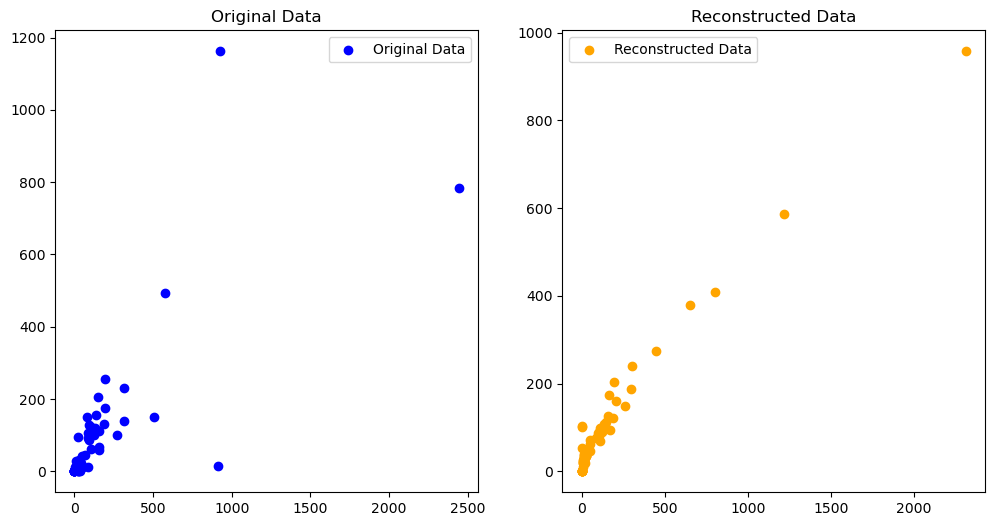

In [8]:
import numpy as np
from sklearn.decomposition import NMF
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


X = X_train
X = np.abs(X)  # Ensure the data is non-negative

# Define the number of components (rank) for the factorization
n_components = 2

# Initialize NMF with the desired number of components
nmf = NMF(n_components=n_components, init='random', random_state=42)

# Fit the NMF model to the data and transform it to the lower-dimensional representation
W = nmf.fit_transform(X)  # Low-dimensional representation
H = nmf.components_  # Basis vectors

# Reconstruct the original matrix from the factorized matrices
X_reconstructed = np.dot(W, H)

# Calculate the total squared error between the original and reconstructed matrices
total_squared_error = np.sum((X - X_reconstructed) ** 2)

# Calculate the total variance in the original matrix
total_variance = np.sum((X - np.mean(X, axis=0)) ** 2)

# Calculate the fraction of variance explained
explained_variance_ratio = 1 - (total_squared_error / total_variance)

print("Explained Variance Ratio:", explained_variance_ratio)

# Plotting to visualize the factorization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Data")
plt.scatter(X[:, 0], X[:, 1], c='blue', label='Original Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Reconstructed Data")
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], c='orange', label='Reconstructed Data')
plt.legend()

plt.show()

## Sparse PCA 

Sparse Principal Component Analysis (Sparse PCA) is a variant of PCA that aims to find principal components with a smaller number of non-zero loadings (sparsity), resulting in more interpretable components. Sparse PCA introduces sparsity constraints into the PCA optimization process, allowing for simpler models.

We initialize SparsePCA with n_components and an alpha value to control the level of sparsity.
After fitting Sparse PCA, we obtain the low-dimensional representation (W) and the sparse basis vectors (H).
The original matrix is reconstructed from these components, and the explained variance ratio is calculated by comparing the total squared error between the original and reconstructed matrices with the total variance in the original matrix.
The code also provides a visualization of the original data and the reconstructed data to help understand how much information is retained.

Explained Variance Ratio: 0.8731672892723096


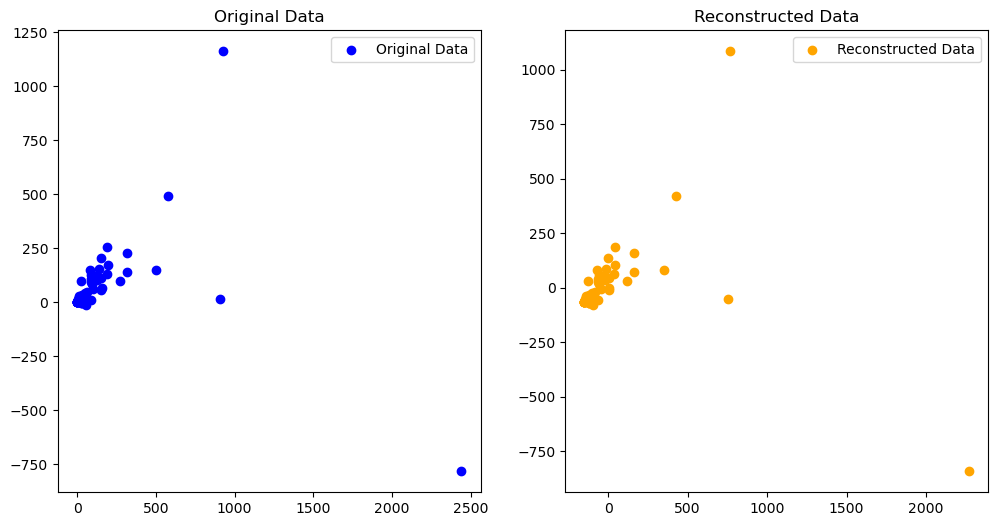

In [11]:
import numpy as np
from sklearn.decomposition import SparsePCA
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Create a random dataset
X = X_train

# Define the number of components for Sparse PCA
n_components = 12

# Initialize Sparse PCA with the desired number of components and sparsity level
sparse_pca = SparsePCA(n_components=n_components, alpha=1, random_state=42)

# Fit Sparse PCA to the data and get the low-dimensional representation
W = sparse_pca.fit_transform(X)  # Low-dimensional representation
H = sparse_pca.components_  # Sparse basis vectors

# Reconstruct the original matrix from the sparse components
X_reconstructed = np.dot(W, H)

# Calculate the total squared error between the original and reconstructed matrices
total_squared_error = np.sum((X - X_reconstructed) ** 2)

# Calculate the total variance in the original matrix
total_variance = np.sum((X - np.mean(X, axis=0)) ** 2)

# Calculate the fraction of explained variance
explained_variance_ratio = 1 - (total_squared_error / total_variance)

print("Explained Variance Ratio:", explained_variance_ratio)

# Plotting to visualize the original data and reconstructed data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Data")
plt.scatter(X[:, 0], X[:, 1], c='blue', label='Original Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Reconstructed Data")
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], c='orange', label='Reconstructed Data')
plt.legend()

plt.show()

## Truncated SVD 

How to use TruncatedSVD to perform dimensionality reduction with a specified number of components.
Reconstruction of the original matrix from the Truncated SVD components (W and H).
Calculation of the total squared error and total variance to derive the explained variance ratio, indicating how much of the original variance is retained after truncation.
A visualization of the original data versus the reconstructed data to illustrate the difference.

Explained Variance Ratio: 1.0


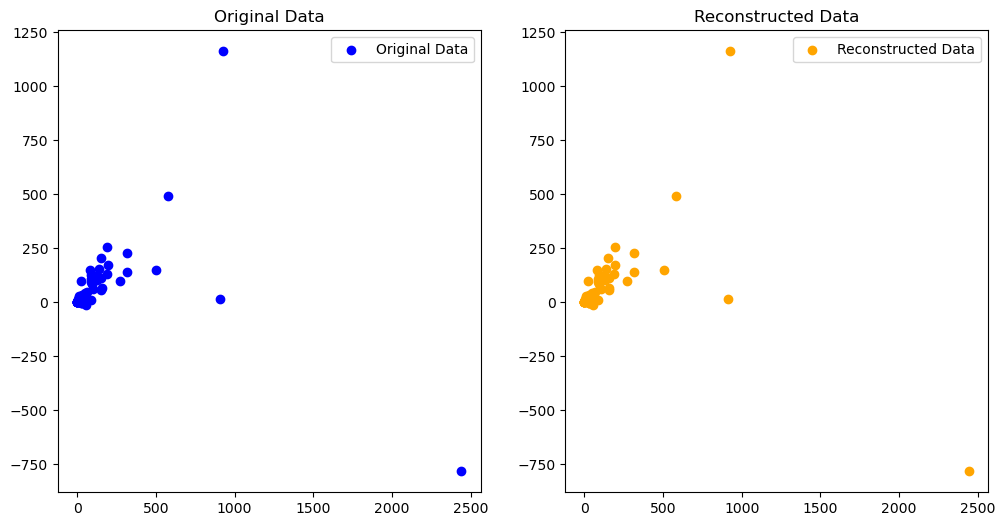

In [12]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Create a random dataset
X = X_train

# Define the number of components for Truncated SVD
n_components = 12

# Initialize Truncated SVD with the desired number of components
truncated_svd = TruncatedSVD(n_components=n_components, random_state=42)

# Fit Truncated SVD to the data and get the low-dimensional representation
W = truncated_svd.fit_transform(X)  # Low-dimensional representation
H = truncated_svd.components_  # Basis vectors (not sparse)

# Reconstruct the original matrix from the components
X_reconstructed = np.dot(W, H)

# Calculate the total squared error between the original and reconstructed matrices
total_squared_error = np.sum((X - X_reconstructed) ** 2)

# Calculate the total variance in the original matrix
total_variance = np.sum((X - np.mean(X, axis=0)) ** 2)

# Calculate the fraction of explained variance
explained_variance_ratio = 1 - (total_squared_error / total_variance)

print("Explained Variance Ratio:", explained_variance_ratio)

# Plotting to visualize the original data and reconstructed data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Data")
plt.scatter(X[:, 0], X[:, 1], c='blue', label='Original Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Reconstructed Data")
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], c='orange', label='Reconstructed Data')
plt.legend()

plt.show()

## Random Projection

Random Projection is a technique for dimensionality reduction that projects data into a lower-dimensional space using random matrices. It's typically used when dealing with high-dimensional data and leverages the Johnson-Lindenstrauss lemma to ensure that distances between points are approximately preserved.

Explained Variance Ratio: -23.851303161807593


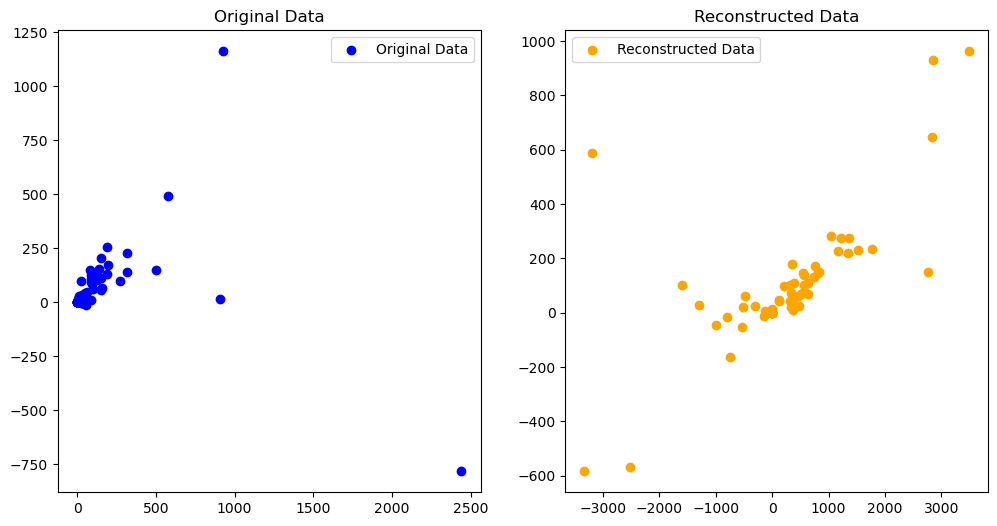

In [14]:
import numpy as np
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Create a random dataset with high dimensionality
X = X_train

# Define the number of components for the random projection
n_components = 12  # Projection into a lower-dimensional space

# Initialize Gaussian Random Projection
gaussian_projection = GaussianRandomProjection(n_components=n_components, random_state=42)

# Fit the random projection to the data
X_projected = gaussian_projection.fit_transform(X)  # Low-dimensional representation

# Since random projection doesn't inherently provide a means to reconstruct the original data,
# we cannot use it to accurately measure the explained variance as with PCA-based techniques.
# However, we can attempt to approximate the original data by projecting back into the original
# space using the pseudo-inverse of the random projection matrix.

# Get the projection matrix
projection_matrix = gaussian_projection.components_

# Compute the pseudo-inverse of the projection matrix
pseudo_inverse = np.linalg.pinv(projection_matrix)

# Reconstruct the original matrix by projecting back
X_reconstructed = np.dot(X_projected, pseudo_inverse)

# Calculate the total squared error between the original and reconstructed matrices
total_squared_error = np.sum((X - X_reconstructed) ** 2)

# Calculate the total variance in the original matrix
total_variance = np.sum((X - np.mean(X, axis=0)) ** 2)

# Calculate the fraction of explained variance
explained_variance_ratio = 1 - (total_squared_error / total_variance)

print("Explained Variance Ratio:", explained_variance_ratio)

# Plotting to visualize the original data and reconstructed data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Data")
plt.scatter(X[:, 0], X[:, 1], c='blue', label='Original Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Reconstructed Data")
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], c='orange', label='Reconstructed Data')
plt.legend()

plt.show()

Demonstrates Gaussian Random Projection for dimensionality reduction.
Attempts to reconstruct the original data by using the pseudo-inverse of the random projection matrix. This is a rough approximation, as random projections are generally not invertible.
Calculates the explained variance ratio by comparing the total squared error and total variance.
Visualizes the original data and the reconstructed data to illustrate the differences.
It's important to note that random projection is designed to preserve distances and is generally used when exact reconstruction is not required. Therefore, unlike PCA-based techniques, it's not typically used to measure explained variance. However, this example shows how to approximate the explained variance when using random projection.

The total variance in the original data is calculated as the sum of the variances along each feature (after centering around the mean).
The variance explained by the reduced components depends on the technique used. In PCA and Truncated SVD, it's determined by the singular values or eigenvalues.